In [1]:
import timeit
import matplotlib.pyplot as plt
import pickle
from time import time
import numpy as np

In [2]:
import sys
sys.path.append("../dnn_from_scratch")

In [3]:
from matplotlib.image import imread
import cv2

In [4]:
DATA_DIR="../Celeb100k/100k"
with open(DATA_DIR+".txt","r") as f:
    names=f.read().split('\n')[:-1]

In [5]:
def get_batch(st,btsz):
    X_train=[]
    for ii in names[st:st+btsz]:
        img=imread(DATA_DIR+"/100k/"+ii)
#         img=cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_AREA)
        X_train.append(img/255*2-1)
    return np.asarray(X_train,dtype=np.float32)

In [6]:
from nnet.network import Sequential,layers
from nnet.layers import conv2d,max_pool,flatten,dense,dropout,conv2d,conv2dtranspose,upsampling,reshape,BatchNormalization,Activation
from nnet import functions
from nnet import optimizers
import numpy as np

Seed: 623
Seed: 534


In [29]:
def generator():
    model=Sequential()
    model.add(dense(8*8*512,activation=functions.leakyRelu,input_shape=100))
    model.add(reshape((8,8,512)))
    model.add(conv2dtranspose(512,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2dtranspose(256,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2dtranspose(128,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2dtranspose(64,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(3,kernel_size=3,activation=functions.tanh))
    return model
g=generator()
g.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 100)                echo             0
__________________________________________________________________________________________
0 dense(dense)            (None, 32768)              leakyRelu        3309568
__________________________________________________________________________________________
1 reshape(reshape)        (None, 8, 8, 512)          echo             0
__________________________________________________________________________________________
2 conv2dtranspose(conv2dt (None, 16, 16, 512)        echo             2359808
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 16, 16, 512)        echo             2048
__________________________________________________________________________________________
4

In [30]:
def discriminator():
    model=Sequential()
    model.add(conv2d(64,kernel_size=3,stride=[2,2],input_shape=(128,128,3)))
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(128,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(256,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(conv2d(512,kernel_size=3,stride=[2,2]))
    model.add(BatchNormalization())
    model.add(Activation(functions.leakyRelu))
    model.add(flatten())
    model.add(dense(1,activation=functions.sigmoid))
    return model
d=discriminator()
d.summary()

⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽⎽
Layer (type)               Output Shape             Activation        Param #
- input_layer(InputLayer) (None, 128, 128, 3)        echo             0
__________________________________________________________________________________________
0 conv2d(conv2d)          (None, 64, 64, 64)         echo             1792
__________________________________________________________________________________________
1 Activation(Activation)  (None, 64, 64, 64)         leakyRelu        0
__________________________________________________________________________________________
2 conv2d(conv2d)          (None, 32, 32, 128)        echo             73856
__________________________________________________________________________________________
3 BatchNormalization(Batc (None, 32, 32, 128)        echo             512
__________________________________________________________________________________________
4 Activ

In [117]:
g.compile(optimizer=optimizers.adam,loss=functions.mean_squared_error,learning_rate=0.0005,beta=0.7)
d.compile(optimizer=optimizers.adam,loss=functions.cross_entropy_with_logits,learning_rate=0.0005,beta=0.7)

In [70]:
svdnoise=np.random.randn(16,100).astype(np.float32)
gen=g.predict(svdnoise)

In [86]:
def gen_sample():
    noise=np.random.randn(1,100).astype(np.float32)
    gen=g.predict(noise)
    plt.imshow((gen[0]+1)/2,interpolation='bicubic')
    plt.show()
    print(d.predict(gen)[0])

In [95]:
def gen_grid(noise,show=True,save=False):
    fig, ax = plt.subplots(nrows=4,ncols=4,figsize=[20,20],gridspec_kw = {'wspace':0, 'hspace':0})
    fig.patch.set_facecolor('white')
    gen=g.predict(noise)
    for i,axi in enumerate(ax.flat):
        axi.axis("off")
        axi.imshow((gen[i].squeeze()+1)/2,interpolation='bicubic')
    if save:
        fig.savefig("timelapse/"+str(ccu)+"img"+str(np.random.randn())[:5]+".png",bbox_inches='tight')
    if not show:
        plt.close(fig)

In [73]:
ccu=0

In [100]:
def run(batch_size=16):
    global ccu,svdnoise
    dsz=len(names)
    # Label real ones as 90% real
    y_fake=np.zeros((batch_size,1),dtype=np.float32)
    y_real=np.ones((batch_size,1),dtype=np.float32)
    y_gen=np.ones((batch_size,1),dtype=np.float32)
    for step in range(dsz//batch_size):
        # Get random real images
        real_images=get_batch(ccu,batch_size)
        ccu+=batch_size
        if ccu>len(names):
            ccu=0
            break
        stt=time()
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Generate fake images from noise
        generated_images=g.predict(noise)
        # Train discriminator
        y_fake=np.random.uniform(0,0.05,(batch_size,1)).astype(np.float32)
        y_real=np.random.uniform(0.95,1,(batch_size,1)).astype(np.float32)
        dout1=d.train_on_batch(real_images,y_real)
        dout2=d.train_on_batch(generated_images,y_fake)
        dloss=functions.cross_entropy(logits=dout2,labels=y_fake).sum()
        # Treat noised input of generator as real data
#         err=np.array(0)
        noise=np.random.randn(batch_size,100).astype(np.float32)
        # Train generator
        gout=g.forward(noise)
        # do not train discriminator and find delta for generator
        dout,err=d.not_train_on_batch(gout,y_gen)
        # backpropogate the generator and update weights
        g.backprop(err,g.lenseq_m1)
        g.optimizer(g.sequence,g.learning_rate,g.beta)
        if not step%120 and step>0:
            print("\nSaving grid.")
            gen_grid(svdnoise[:25],show=False,save=True)
            gen_sample()
        print("\rProgress: {:.2f} %    {}    Dloss: {}    err: {}    Step time: {:.3f}s    _".format(step*batch_size*100/dsz,ccu,dloss,abs(err).sum(),time()-stt),end='')
        if (time()-stt)>22:
            print("\nLOOOOONNNNGGGG")
    if ccu>len(names):
        ccu=0

EPOCH: 1 / 10
Progress: 1.90 %    49760    Dloss: 4.372483253479004    err: 7594.728515625    Step time: 11.102s    ____
Saving grid.


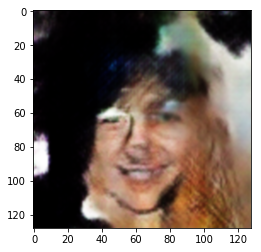

[ 0.55470616]
Progress: 2.22 %    50080    Dloss: 7.766355037689209    err: 11564.2958984375    Step time: 11.146s    __

In [ ]:
epochs=10
for epoch in range(epochs):
    print("EPOCH:",epoch+1,'/',epochs)
    st_tm=time()
    run(16)
    print("\nEpoch time: {}:{}s".format(int(time()-st_tm)//60,int(time()-st_tm)%60))

## # Using generator with just batch size 1 for first time is causing images to be generated extreme

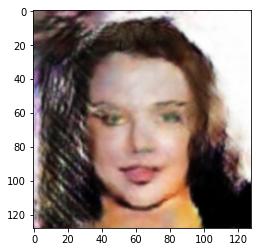

[ 0.21204996]


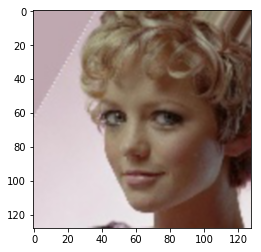

[[ 0.7820875]]


In [127]:
noise=np.random.randn(16,100).astype(np.float32)
gen=g.predict(noise)
gen_sample()
img=get_batch(np.random.randint(low=0,high=len(names)),1)
plt.imshow((img[0]+1)/2,interpolation='bicubic')
plt.show()
print(d.predict(img))

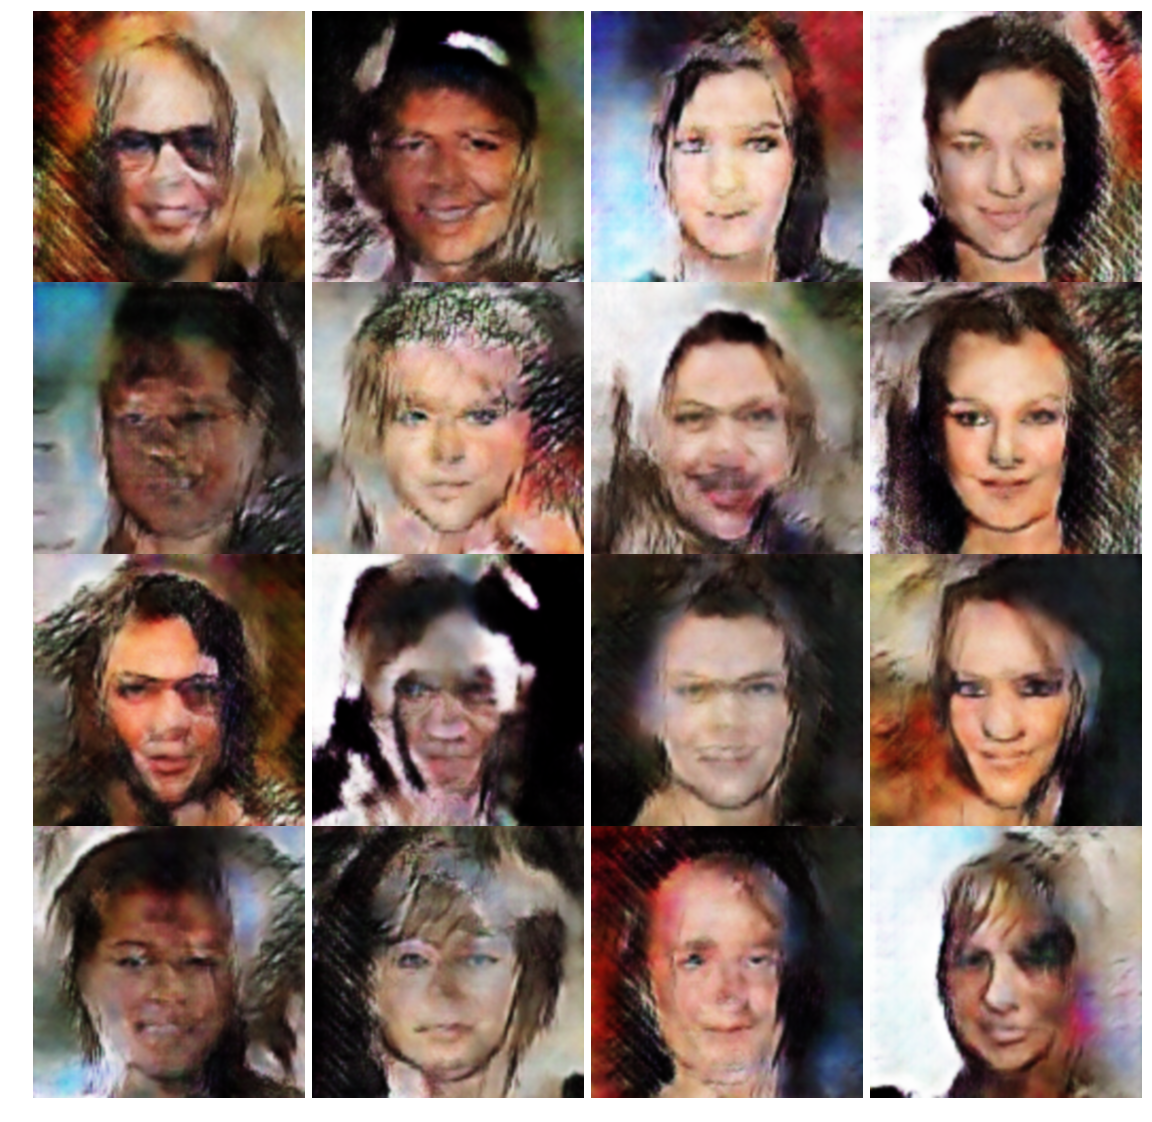

In [133]:
noise=np.random.randn(16,100).astype(np.float32)
gen_grid(noise)

In [ ]:
# g.load_weights("generator.w8s")
# d.load_weights("discriminator.w8s")

In [129]:
g.save_weights("generator.w8s")
d.save_weights("discriminator.w8s")

[!] Load and save is bugged. You can use it for saving,loading and prediction but training further from loaded weights isn't working.
[!] Load and save is bugged. You can use it for saving,loading and prediction but training further from loaded weights isn't working.
